## Importing the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.models import Model
from wordcloud import WordCloud
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, MaxPool1D, Dropout, Dense, GlobalMaxPooling1D, Embedding, Activation

In [7]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the datasets

In [8]:
train_df = pd.read_csv(".//dataset//train.csv")
validation_df = pd.read_csv(".//dataset//validation.csv")
test_df = pd.read_csv(".//dataset//test.csv")

In [9]:
train_df.shape, validation_df.shape, test_df.shape

((120000, 2), (20000, 2), (20000, 2))

## Combining all the datasets together

In [10]:
df = pd.concat([train_df,validation_df,test_df],axis=0)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,comment_text,toxic
0,Maybe she is getting paid more to fix what her...,1
1,"Pelasgian , pre-greek origin of Zeus \n\nHomer...",0
2,"Keep your darn kids out of them, then.",1
3,Who are you to hijack the Maldives pages and a...,0
4,Expand\nplease expand this article.,0


## Feature Engineering

In [11]:
df.shape

(160000, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  160000 non-null  object
 1   toxic         160000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [13]:
df.isna().sum()

comment_text    0
toxic           0
dtype: int64

In [14]:
df.duplicated().sum()

749

In [15]:
df = df.drop_duplicates()
df.shape

(159251, 2)

In [16]:
df.comment_text.str.isspace().sum()

0

In [17]:
df.toxic.unique()

array([1, 0], dtype=int64)

In [18]:
#df = pd.concat([df[df['toxic'] == 0][:3000],df[df['toxic'] == 1][:3000]],axis=0)

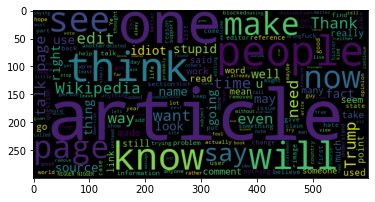

In [19]:
wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.comment_text))
plt.imshow(wc);

D:\Winpython\WPy64-31050\python-3.10.5.amd64\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


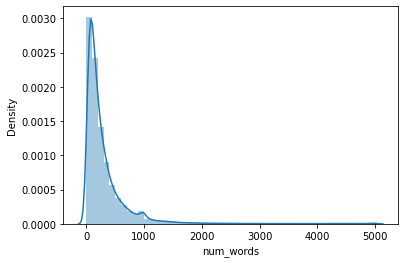

In [21]:
df['num_words'] = df.comment_text.apply(len)
sns.distplot(df.num_words);

In [22]:
df.num_words.describe()

count    159251.000000
mean        324.575017
std         493.283090
min           1.000000
25%          84.000000
50%         178.000000
75%         366.000000
max        5000.000000
Name: num_words, dtype: float64

In [23]:
max_len = 320

D:\Winpython\WPy64-31050\python-3.10.5.amd64\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


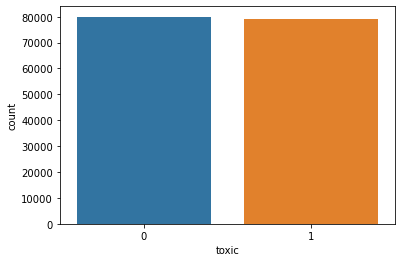

In [24]:
sns.countplot(df.toxic);

The classes are equally balanced.

## Text Preprocessing

In [25]:
import re
def text_preprocess(sen):
    # lower the character
    sentence = sen.lower()
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

In [28]:
df['comment_text'] = df['comment_text'].apply(text_preprocess)
df.head()

,comment_text,toxic,num_words
0,Maybe she is getting paid more to fix what her...,1,70
1,Pelasgian pre greek origin of Zeus Homer refer...,0,204
2,Keep your darn kids out of them then,1,38
3,Who are you to hijack the Maldives pages and a...,0,297
4,Expand please expand this article,0,34


# Fully Connected Neural Neywork

In [29]:
# tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
token = Tokenizer(28164)
token.fit_on_texts(df['comment_text'])
text = token.texts_to_sequences(df['comment_text'])
text = pad_sequences(text, maxlen=100)

In [30]:
y = df['toxic'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.2, random_state=1, stratify=y)

In [32]:
# build the model

max_features = 28164
embedding_dim = 32

model = Sequential()
model.add(Input(shape=100))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                260       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
 activation (Activation)     (None, 1)                 0

In [ ]:
# compile and train model



r = model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
3982/3982 [==============================] - 20s 4ms/step - loss: 48.6286 - accuracy: 0.5042 - val_loss: 2.8953 - val_accuracy: 0.5121
Epoch 2/15
3982/3982 [==============================] - 16s 4ms/step - loss: 3.4860 - accuracy: 0.5017 - val_loss: 1.0779 - val_accuracy: 0.5432
Epoch 3/15
3982/3982 [==============================] - 16s 4ms/step - loss: 1.2028 - accuracy: 0.5093 - val_loss: 0.8471 - val_accuracy: 0.4901
Epoch 4/15
3982/3982 [==============================] - 16s 4ms/step - loss: 0.8012 - accuracy: 0.5069 - val_loss: 0.7334 - val_accuracy: 0.5333
Epoch 5/15
3982/3982 [==============================] - 17s 4ms/step - loss: 0.7663 - accuracy: 0.5107 - val_loss: 0.7023 - val_accuracy: 0.5439
Epoch 6/15
3982/3982 [==============================] - 17s 4ms/step - loss: 0.7596 - accuracy: 0.5126 - val_loss: 0.7069 - val_accuracy: 0.5357
Epoch 7/15
3982/3982 [==============================] - 17s 4ms/step - loss: 0.7553 - accuracy: 0.5112 - val_loss: 0.7765 - val_a

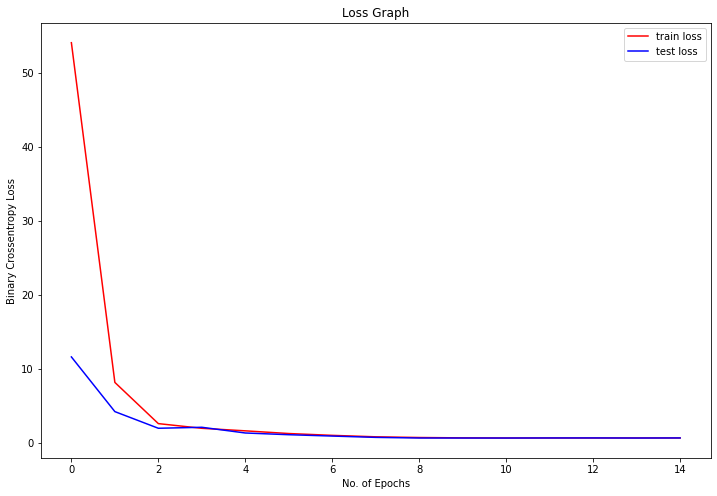

In [227]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

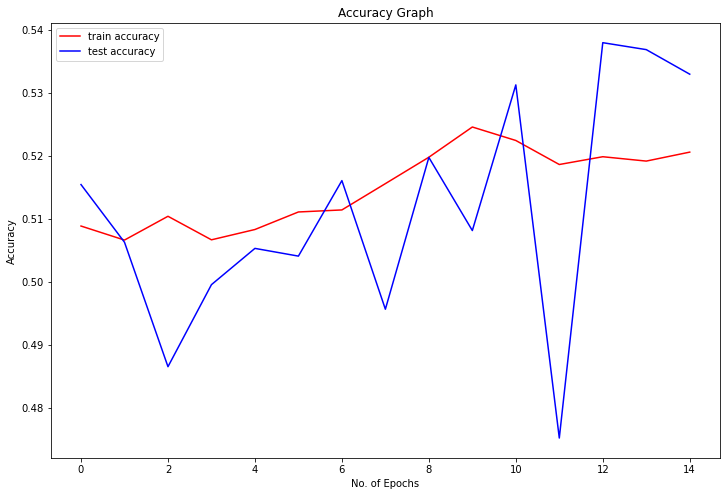

In [228]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [229]:
loss, acc = model.evaluate(X_test,y_test)
print("Test Binary Cross-entropy Loss:", loss)
print("Test Accuracy:", acc)

996/996 [==============================] - 2s 2ms/step - loss: 0.7072 - accuracy: 0.5329
Test Binary Cross-entropy Loss: 0.7071635127067566
Test Accuracy: 0.5329189300537109


# LSTM

In [253]:
X = df.comment_text
Y = df.toxic.values

Y = Y.reshape(-1,1)

In [254]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [255]:
X_train.shape

(135363,)

In [256]:
from tensorflow.keras.preprocessing import sequence
from keras.optimizers import RMSprop
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [257]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [258]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_17 (Embedding)    (None, 150, 50)           50000     
                                                                 
 lstm_21 (LSTM)              (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_31 (Activation)  (None, 256)               0         
                                                                 
 dropout_136 (Dropout)       (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [259]:
r = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=3,
          validation_split=0.2)

Epoch 1/3
847/847 [==============================] - 660s 762ms/step - loss: 0.2937 - accuracy: 0.8763 - val_loss: 0.2681 - val_accuracy: 0.8858
Epoch 2/3
847/847 [==============================] - 456s 538ms/step - loss: 0.2452 - accuracy: 0.8990 - val_loss: 0.2431 - val_accuracy: 0.9000
Epoch 3/3
847/847 [==============================] - 329s 388ms/step - loss: 0.2355 - accuracy: 0.9018 - val_loss: 0.2445 - val_accuracy: 0.8996


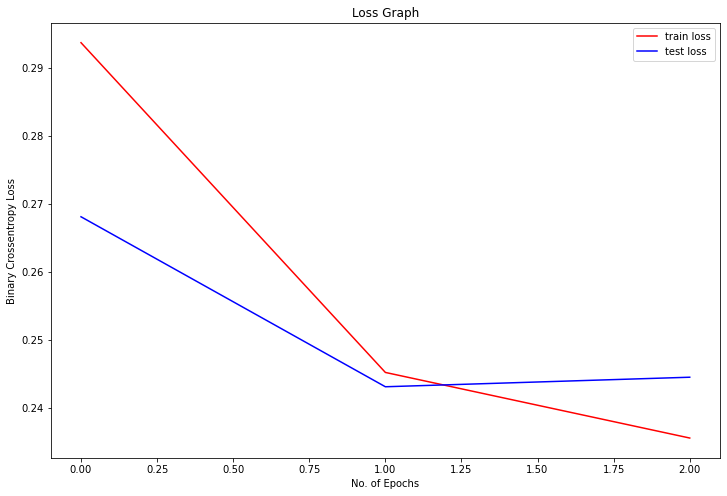

In [266]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

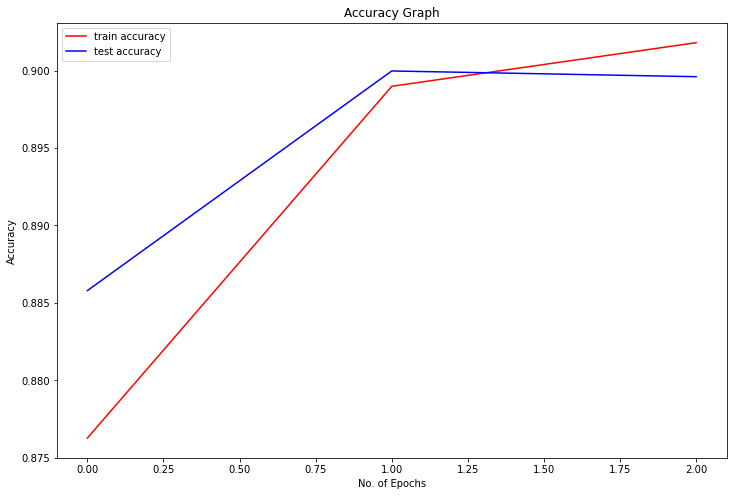

In [267]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [268]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [269]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

747/747 [==============================] - 75s 100ms/step - loss: 0.2430 - accuracy: 0.9002
Test set
  Loss: 0.243
  Accuracy: 0.900


In [274]:
def test(sent):
    test_sequences = tok.texts_to_sequences(pd.Series([sent]))
    test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
    test_sequences_matrix
    prediction = model.predict(test_sequences_matrix)
    print(prediction[0])
    if prediction[0] > .5 :
        print("Toxic Comment") 
    else:    
        print("Not Toxic")

In [275]:
sent = "I am fed up of this idiots and i want to bully them"
test(sent)

1/1 [==============================] - 0s 47ms/step
[0.98881984]
Toxic Comment
